In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random

# Muat model yang telah disimpan
model_path = '../models/plant_disease_model.h5'
model = tf.keras.models.load_model(model_path)

# Tampilkan ringkasan model untuk memastikan berhasil dimuat
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Layer (type)            ┃ Output Shape      ┃   Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ input_layer_1           │ (None, 224, 224,  │         0 │
│ (InputLayer)            │ 3)                │           │
├─────────────────────────┼───────────────────┼───────────┤
│ mobilenetv2_1.00_224    │ (None, 7, 7,      │ 2,257,984 │
│ (Functional)            │ 1280)             │           │
├─────────────────────────┼───────────────────┼───────────┤
│ global_average_pooling… │ (None, 1280)      │         0 │
│ (GlobalAveragePooling2… │                   │           │
├─────────────────────────┼───────────────────┼───────────┤
│ dropout (Dropout)       │ (None, 1280)      │         0 │
├─────────────────────────┼───────────────────┼───────────┤
│ dense (Dense)           │ (None, 1024)      │ 1,311,744 │
├─────────────────────────┼───────────────────┼───────────┤
│ dense_1 (Dense)         │ (None, 15)        │    15,375 │
└─────────────────────────┴───────────────────┴───────────┘

 Total params: 3,585,105 (13.68 MB)

 Trainable params: 1,327,119 (5.06 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2 (12.00 B)

In [2]:
# Kita perlu membuat ulang ImageDataGenerator untuk mendapatkan class_indices
# Tidak perlu augmentasi, hanya rescale saja
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Path ke dataset
dataset_path = '../data/plantvillage/'
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32

# Gunakan flow_from_directory hanya untuk mendapatkan mapping kelas
# Kita tidak akan menggunakannya untuk training/validasi di sini
generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Tidak perlu diacak
)

# Dapatkan kamus yang memetakan nama kelas ke indeks
class_indices = generator.class_indices

# Kita perlu membaliknya agar bisa mencari nama kelas dari indeks output model
# Contoh: {0: 'Pepper__bell___Bacterial_spot', 1: 'Pepper__bell___healthy', ...}
class_names = {v: k for k, v in class_indices.items()}

print("Class Names Mapping:")
print(class_names)

Found 20638 images belonging to 15 classes.
Class Names Mapping:
{0: 'Pepper__bell___Bacterial_spot', 1: 'Pepper__bell___healthy', 2: 'Potato___Early_blight', 3: 'Potato___Late_blight', 4: 'Potato___healthy', 5: 'Tomato_Bacterial_spot', 6: 'Tomato_Early_blight', 7: 'Tomato_Late_blight', 8: 'Tomato_Leaf_Mold', 9: 'Tomato_Septoria_leaf_spot', 10: 'Tomato_Spider_mites_Two_spotted_spider_mite', 11: 'Tomato__Target_Spot', 12: 'Tomato__Tomato_YellowLeaf__Curl_Virus', 13: 'Tomato__Tomato_mosaic_virus', 14: 'Tomato_healthy'}


In [3]:
def predict_image(image_path, model):
    """
    Fungsi untuk memuat gambar, memprosesnya, dan membuat prediksi.
    """
    # 1. Muat gambar menggunakan OpenCV
    img = cv2.imread(image_path)
    # Konversi dari BGR (OpenCV) ke RGB (Matplotlib)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 2. Preprocessing gambar agar sesuai dengan input model
    #    - Resize ke 224x224
    #    - Normalisasi (rescale)
    #    - Tambah dimensi batch
    img_resized = cv2.resize(img_rgb, (IMG_WIDTH, IMG_HEIGHT))
    img_array = np.expand_dims(img_resized, axis=0) # Tambah dimensi batch -> (1, 224, 224, 3)
    img_scaled = img_array / 255.0 # Normalisasi
    
    # 3. Buat prediksi
    prediction = model.predict(img_scaled)
    
    # 4. Dapatkan indeks kelas dengan probabilitas tertinggi
    predicted_class_index = np.argmax(prediction)
    
    # 5. Dapatkan nama kelas dari indeks
    predicted_class_name = class_names[predicted_class_index]
    
    # 6. Dapatkan confidence score (probabilitas)
    confidence = np.max(prediction)
    
    # Tampilkan gambar dan hasilnya
    plt.imshow(img_rgb)
    plt.title(f"Prediksi: {predicted_class_name}\nConfidence: {confidence:.2%}")
    plt.axis('off')
    plt.show()
    
    return predicted_class_name, confidence

Gambar yang diuji: ../data/plantvillage/Pepper__bell___healthy\147582b1-0d36-4409-8810-1fd5d4304388___JR_HL 5977.JPG
Kelas Sebenarnya: Pepper__bell___healthy
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


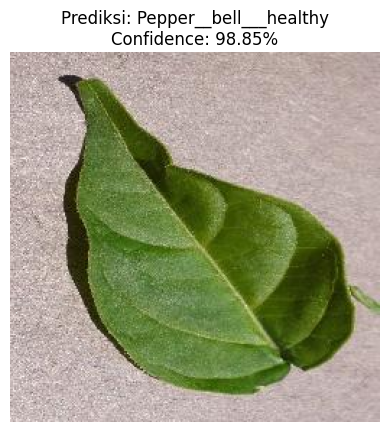

In [4]:
# Pilih folder kelas secara acak
random_class_folder = random.choice(list(class_names.values()))
class_folder_path = os.path.join(dataset_path, random_class_folder)

# Pilih gambar secara acak dari folder tersebut
random_image_file = random.choice(os.listdir(class_folder_path))
test_image_path = os.path.join(class_folder_path, random_image_file)

print(f"Gambar yang diuji: {test_image_path}")
print(f"Kelas Sebenarnya: {random_class_folder}")
print("-" * 30)

# Panggil fungsi prediksi kita
predicted_class, confidence = predict_image(test_image_path, model)